In [1]:
import dolfinx.mesh as msh
import dolfinx.fem as fem
import mpi4py.MPI as mpi

import dolfinx.plot as dolplot
import ufl
import pyvista

import numpy as np
import petsc4py.PETSc as pet

In [2]:
import matplotlib.pyplot as plt

### Solve

In [3]:
domain= msh.create_unit_square ( mpi.COMM_WORLD,10,10, msh.CellType.quadrilateral )
space= fem.FunctionSpace(domain, ('CG',1))

In [4]:
u0_express=lambda x: 1 + x[0]**2 + 2 * x[1]**2
u0 = fem.Function(space)
u0.interpolate(u0_express);

In [5]:
spacedim= domain.topology.dim
domain.topology.create_connectivity(spacedim-1,spacedim)
bound_facet=msh.compute_boundary_facets(domain.topology)
bound_facet=np.flatnonzero(bound_facet)

In [6]:
bound_dofs = fem.locate_dofs_topological(space, spacedim - 1, bound_facet)
bc = fem.dirichletbc(u0, bound_dofs)

In [7]:
u = ufl.TrialFunction(space)
v = ufl.TestFunction(space)

In [8]:
f = fem.Constant(domain, np.float64(-6))

In [9]:
# Dot = ufl.dot
Dot=ufl.inner
Grad = ufl.grad
dx = ufl.dx


In [10]:
a = Dot(Grad(u), Grad(v)) *dx
L = f * v * dx

In [11]:
problem= fem.petsc.LinearProblem(a,L,bcs=[bc],petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

In [12]:
uh = problem.solve()

### Error

In [13]:
space2=fem.FunctionSpace(domain,('CG',2))
u_extrapol=fem.Function(space2)
u_extrapol.interpolate(u0_express)

In [14]:
l2_error= fem.form(Dot(uh-u_extrapol,uh-u_extrapol)*dx)
error_local=fem.assemble_scalar(l2_error)
erorr_l2=np.sqrt(domain.comm.allreduce(error_local,op=mpi.SUM))

error_max= np.max(
    np.abs(u0.x.array-uh.x.array)
)
print(f'Error max: {error_max:.2e}')
print(f'Error: {erorr_l2:.2e}')

Error max: 2.66e-15
Error: 5.27e-03


### Visualise pyvista

In [15]:
u_topology, u_cell_types, u_geometry = dolplot.create_vtk_mesh(space)   
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)

pyvista.set_jupyter_backend("pythreejs")
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()

pyvista.OFF_SCREEN = False
if not pyvista.OFF_SCREEN:
    u_plotter.show()
else:
    pyvista.start_xvfb()
    figure = u_plotter.screenshot("fundamentals_mesh.png")    

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

In [16]:
if not pyvista.OFF_SCREEN:
    warped = u_grid.warp_by_scalar()
    plotter2 = pyvista.Plotter()
    plotter2.add_mesh(warped, show_edges=True, show_scalar_bar=True)
    plotter2.show(jupyter_backend="ipygany")

AppLayout(children=(VBox(children=(HTML(value='<h3>u</h3>'), Dropdown(description='Colormap:', options={'BrBG'…

In [17]:
from dolfinx import io
with io.VTKFile(domain.comm, "output.pvd", "w") as vtk:
    vtk.write([uh._cpp_object])
with io.XDMFFile(domain.comm, "output.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(uh)

### Visualise Matplot

In [30]:
u_topology, u_cell_types, u_geometry=dolplot.create_vtk_mesh(space) 
print(
len(u_geometry),
len(uh.x.array),
)

data=np.column_stack((u_geometry[:,0:2],uh.x.array))
x_data= data[:,0]
y_data=data[:,1]
z_data=data[:,2]

121 121


ValueError: `bins[0]` must be monotonically increasing, when an array

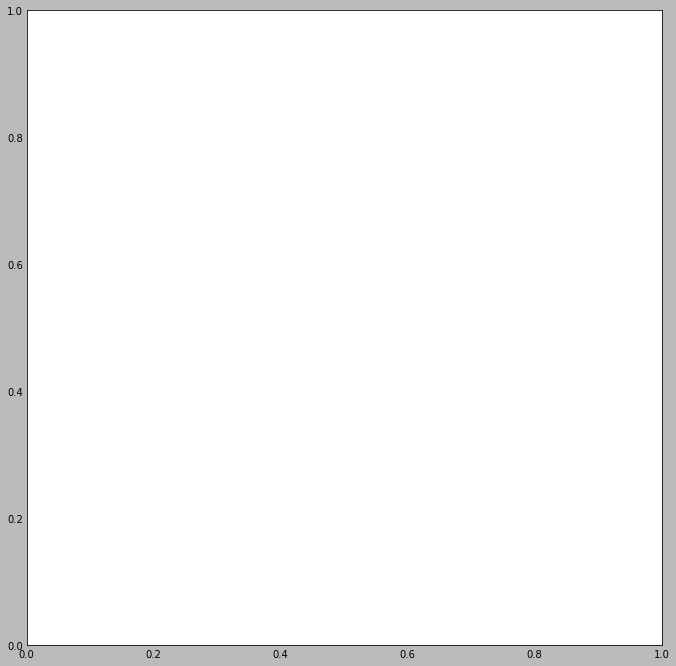

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
fig.set_facecolor('#BBB')
# ax.contourf(x_data,y_data,z_data)
ax.hist2d(x_data,y_data,bins=z_data)

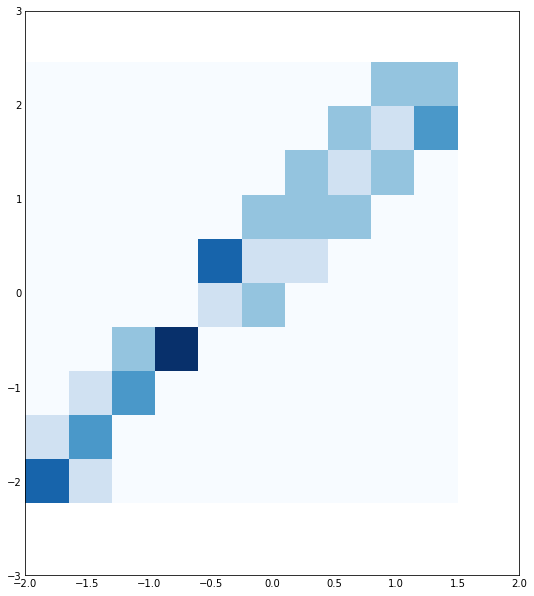

In [61]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
x = np.linspace(-2,1.5,50)
y = 1.2 * x + np.random.random(50)

# plot:
fig, ax = plt.subplots(figsize=(7,8))


ax.hist2d(x, y)
# ax.hist2d(x, y, bins=(np.arange(-3, 3, 0.1), np.arange(-3, 3, 0.1)))

ax.set(xlim=(-2, 2), ylim=(-3, 3))

plt.show()

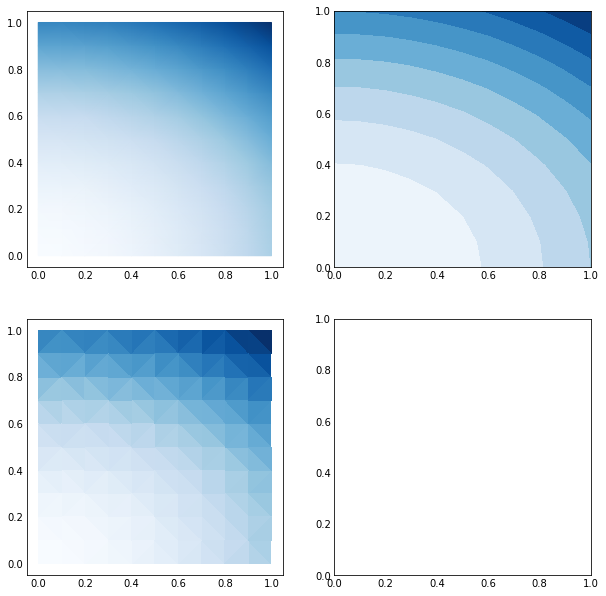

In [88]:
levels = np.linspace(z_data.min(), z_data.max(), 10)
fig, ax = plt.subplots(2,2,figsize=(8,8))

ax[0,0].tripcolor(x_data, y_data, z_data,shading='gouraud')
ax[0,1].tricontourf(x_data, y_data, z_data, levels=levels)
ax[1,0].tripcolor(x_data, y_data, z_data,shading='flat')
